# Example: Chlamydia in England, 2012

This example illustrates a method for using chlamydia surveillance data to estimate prevalence. Surveillance data on chlamydia testing and diagnosis rates in England in 2012 were downloaded from: http://www.chlamydiascreening.nhs.uk/ps/data.asp (downloaded 17 April 2015).


|           | Men         |             |       |Women       |             |        |
|-----------|-------------|-------------|-------|------------|-------------|--------|
|           | 15-19 years | 20-24 years | Total |15-19 years | 20-24 years | Total  |
|Population |1685620      | 1833395     |3519015|1600686     |1788156      |3388842 |
|Tests      |232668       | 334240      |566908 |520358      |685538       |1205896 |
|Diagnoses  |15213        | 33174       |48387  |42874       |45227        |88101   |

Data on sexual behaviour from Natsal-3 are available from the UK data service: https://www.ukdataservice.ac.uk/ (downloaded 23 September 2015). These were used to infer 95% confidence intervals for the proportions of men and women, aged 16-19 and 20-24, who were sexually active (see the accompanying R script; note that no 15-year-olds were recruited to Natsal-3). These 95% confidence intervals were in turn used to derive beta-distribution priors for the proportion sexually active within each sex and age group.

## Sampling for testing and diagnosis rates

In [1]:
from numpy import *
from scipy.stats import beta
from scipy.optimize import fsolve

######################
# parameters of beta distributions representing the proportion of the population sexually 
# active, by sex and age group
######################

# men, 16-19
[alpha_m_16_19, beta_m_16_19] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.6747424, 0.741327698),
    [1,1]
    )
# men, 20-24
[alpha_m_20_24, beta_m_20_24] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.8844970, 0.933759842),
    [1,1]
    )
# men, 16-24
[alpha_m_16_24, beta_m_16_24] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.8023836019, 0.843403825),
    [1,1]
    )
# women, 16-19
[alpha_f_16_19, beta_f_16_19] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.6583593, 0.723554878),
    [1,1]
    )
# women, 20-24
[alpha_f_20_24, beta_f_20_24] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.8904135, 0.934417684),
    [1,1]
    )
# women, 16-24
[alpha_f_16_24, beta_f_16_24] = fsolve(
    lambda x: array(beta.interval(0.95, x[0], x[1], loc=0, scale=1))
    - (0.7998634469, 0.837979601),
    [1,1]
    )


Next, sample from distributions for the probability of being sexually active, the size of the sexually active population and the testing and diagnosis rates per person per year.

In [2]:
random.seed = 12345

from scipy.stats import gamma
from numpy.random import normal

n_sample = 10000

# sexually-active populations:
p_active_m_16_19 = random.beta(alpha_m_16_19, beta_m_16_19, size=n_sample) # 16-19 yo only
pop_active_m_15_19 = random.binomial(1685620, p_active_m_16_19, size=n_sample)

p_active_m_20_24 = random.beta(alpha_m_20_24, beta_m_20_24, size=n_sample) # 20-24 yo only
pop_active_m_20_24 = random.binomial(1833395, p_active_m_20_24, size=n_sample)

p_active_m_16_24 = random.beta(alpha_m_16_24, beta_m_16_24, size=n_sample) # 16-24 yo only
pop_active_m_15_24 = random.binomial(3519015, p_active_m_16_24, size=n_sample)

p_active_f_16_19 = random.beta(alpha_f_16_19, beta_f_16_19, size=n_sample) # 16-19 yo only
pop_active_f_15_19 = random.binomial(1600686, p_active_f_16_19, size=n_sample)

p_active_f_20_24 = random.beta(alpha_f_20_24, beta_f_20_24, size=n_sample) # 20-24 yo only
pop_active_f_20_24 = random.binomial(1788156, p_active_f_20_24, size=n_sample)

p_active_f_16_24 = random.beta(alpha_f_16_24, beta_f_16_24, size=n_sample) # 16-24 yo only
pop_active_f_15_24 = random.binomial(3388842, p_active_f_16_24, size=n_sample)

# testing and diagnosis rates, per person per year
test_rate_m_15_19 = random.gamma(232668, 1, size=n_sample)/pop_active_m_15_19
test_rate_m_20_24 = random.gamma(334240, 1, size=n_sample)/pop_active_m_20_24
test_rate_m_15_24 = random.gamma(566908, 1, size=n_sample)/pop_active_m_15_24

diag_rate_m_15_19 = random.gamma(15213, 1, size=n_sample)/pop_active_m_15_19
diag_rate_m_20_24 = random.gamma(33174, 1, size=n_sample)/pop_active_m_20_24
diag_rate_m_15_24 = random.gamma(48387, 1, size=n_sample)/pop_active_m_15_24

diag_rate_f_15_19 = random.gamma(42874, 1, size=n_sample)/pop_active_f_15_19
diag_rate_f_20_24 = random.gamma(45227, 1, size=n_sample)/pop_active_f_20_24
diag_rate_f_15_24 = random.gamma(88101, 1, size=n_sample)/pop_active_f_15_24

test_rate_f_15_19 = random.gamma(520358, 1, size=n_sample)/pop_active_f_15_19
test_rate_f_20_24 = random.gamma(685538, 1, size=n_sample)/pop_active_f_20_24
test_rate_f_15_24 = random.gamma(1205896, 1, size=n_sample)/pop_active_f_15_24

## Sampling natural history, behavioural and other parameters

Priors for the proportion of incident infections which are asymptomatic and the test performance were taken directly from published studies.

In [3]:
# Proportion of incident infections asymptomatic is not known, so we use estimates of the 
# proportion of _prevalent_ infections asymptomatic. Note that these provide an upper bound
# because treatment seeking in symptomatic cases will deplete the symptomatic pool.
p_asymp_m = random.beta(69 + 1, 78 - 69 + 1, size=n_sample) # McKay et al. Lancet (2003) 88% 
p_asymp_f = random.beta(135 + 1, 26 + 1, size=n_sample) # Kahn et al. Sex Transm Dis (2003) 84% NB numbers taken from text, p656

# test performance
p_true_pos_m = random.beta(32+1, 0+1, size=n_sample) # Horner J. Clin. Microbiol (2005): 32 of 32 infected samples tested +ve
p_false_pos_m = random.beta(2+1, 950+1, size=n_sample) # Horner J. Clin. Microbiol (2005): 2 of 952 uninfected samples tested +ve
p_true_pos_f = random.beta(129+1, 12+1, size=n_sample) # Low Health Technol Assess (2007): 129 of 141 infected samples tested +ve
p_false_pos_f = random.beta(4+1, 2323+1, size=n_sample) # Low Health Technol Assess (2007): 4 of 2327 uninfected samples tested +ve

### Rate of treatment seeking by symptomatic cases
We use a Metropolis-Hastings algorithm to sample for the rate of treatment following onset of symptoms, assuming a constant hazard of treatment beginning with the onset of symptoms. Data were obtained from the MSTIC study.

In [4]:
# function for calculating likelihood of multinomial data
%run multinomial_pmf.py

# read data from the MSTIC study (Aicken et al. BMC Health Serv. Res.; 2015)
import csv

# men
with open('../../../data/MSTIC/mstic_timedata_m.csv', 'rU') as csvfile:
    timereader = csv.reader(csvfile, delimiter=',')
    times = [int(row[0]) for row in timereader]
times_m = times[0:37] # exclude waiting times longer than 1 year
with open('../../../data/MSTIC/mstic_timedata_m.csv', 'rU') as csvfile:
    timereader = csv.reader(csvfile, delimiter=',')
    prop = [int(row[1]) for row in timereader]
prop_m = prop[0:37]
with open('../../../data/MSTIC/mstic_timedata_m.csv', 'rU') as csvfile:
    timereader = csv.reader(csvfile, delimiter=',')
    cumprop = [int(row[2]) for row in timereader]
cumprop_m = cumprop[0:37]

# women
with open('../../../data/MSTIC/mstic_timedata_f.csv', 'rU') as csvfile:
    timereader = csv.reader(csvfile, delimiter=',')
    times = [int(row[0]) for row in timereader]
times_f = times[0:43]
with open('../../../data/MSTIC/mstic_timedata_f.csv', 'rU') as csvfile:
    timereader = csv.reader(csvfile, delimiter=',')
    prop = [int(row[1]) for row in timereader]
prop_f = prop[0:43]
with open('../../../data/MSTIC/mstic_timedata_f.csv', 'rU') as csvfile:
    timereader = csv.reader(csvfile, delimiter=',')
    cumprop = [int(row[2]) for row in timereader]
cumprop_f = cumprop[0:43]


In [5]:
# Metropolis-Hastings to get a sample for rate of treatment in men

i = 0
att_symp_m = empty(n_sample+1000) # testing rate per person per year. Allow 1000 extra samples for burn-in
ll_m = empty(n_sample+1000) # log-likelihood
old = 15 # starting sample value
new = 15 # starting sample value
# simulate probabilities corresponding to MSTIC data
simp_new = exp(-array(times_m)*new/365.25) - append(exp(-array(times_m[1:len(times_m)])*new/365.25),0)

acc=0.
while i < n_sample+1000: # to do samples for p_test_symp
    
    new = random.normal(old, 2) # generate a sample from normal distribution
    
    if new < 0:
        att_symp_m[i] = old # reject
        ll_m[i] = -1e10
    else:
        simp_old = exp(-array(times_m)*old/365.25) - append(exp(-array(times_m[1:len(times_m)])*old/365.25), 0)
        simp_new = exp(-array(times_m)*new/365.25) - append(exp(-array(times_m[1:len(times_m)])*new/365.25), 0)

        if sum(simp_new > 0) != len(times_m):
            att_symp_m[i] = old # reject
            ll_m[i] = -1e10
        else:
            # simulate probabilities corresponding to the MSTIC data
            m_old = Multinomial(simp_old)
            m_new = Multinomial(simp_new)
            log_ratio = m_new.log_pmf(prop_m) - m_old.log_pmf(prop_m)
    
            if log(random.uniform(0,1)) <  log_ratio:
                att_symp_m[i] = new # accept
                ll_m[i] = m_new.log_pmf(prop_m)
                old = new
                acc = acc+1
            else:
                att_symp_m[i] = old # reject
                ll_m[i] = m_old.log_pmf(prop_m)
        
    i = i+1
    
att_symp_m = att_symp_m[1000:] # remove burn-in samples
ll_m = ll_m[1000:] # log-likelihood
    
print acc/(n_sample+1000) # print the proportion of samples accepted
print mean(att_symp_m)

0.457272727273
15.3329397466


In [6]:
# Metropolis-Hastings to get a sample for rate of treatment in women

i = 0
att_symp_f = empty(n_sample+1000) # testing rate per person per year
ll_f = empty(n_sample+1000) # log-likelihood
old = 15 # starting sample value
new = 15 # starting sample value
# simulate probabilities corresponding to MSTIC data
simp_new = exp(-array(times_f)*new/365.25) - append(exp(-array(times_f[1:len(times_f)])*new/365.25),0)

acc=0.
while i < n_sample+1000: # to do samples for p_test_symp
    
    new = random.normal(old, 2) # generate a sample from normal distribution
    
    if new < 0:
        att_symp_f[i] = old # reject
        ll_f[i] = -1e10
    else:
        simp_old = exp(-array(times_f)*old/365.25) - append(exp(-array(times_f[1:len(times_f)])*old/365.25), 0)
        simp_new = exp(-array(times_f)*new/365.25) - append(exp(-array(times_f[1:len(times_f)])*new/365.25), 0)

        if sum(simp_new > 0) != len(times_f):
            att_symp_f[i] = old # reject
            ll_f[i] = -1e10
        else:
            # simulate probabilities corresponding to the MSTIC data
            m_old = Multinomial(simp_old)
            m_new = Multinomial(simp_new)
            log_ratio = m_new.log_pmf(prop_f) - m_old.log_pmf(prop_f)
    
            if log(random.uniform(0,1)) <  log_ratio:
                att_symp_f[i] = new # accept
                ll_f[i] = m_new.log_pmf(prop_f)
                old = new
                acc = acc+1
            else:
                att_symp_f[i] = old # reject
                ll_f[i] = m_old.log_pmf(prop_f)
        
    i = i+1
    
att_symp_f = att_symp_f[1000:] # remove burn-in samples
ll_f = ll_f[1000:] # log-likelihood
    
print acc/(n_sample+1000) # print the proportion of samples accepted
print mean(att_symp_f)

0.353272727273
12.3843727776


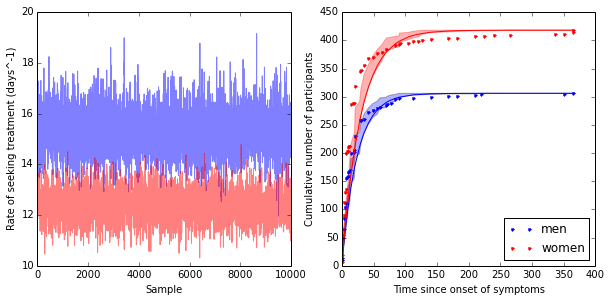

In [7]:
# diagnostics/posterior predictive checks

import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import multinomial

fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(221)
ax1.plot(att_symp_m, alpha=0.5)
ax1.plot(att_symp_f, 'r', alpha=0.5)

ax2 = fig.add_subplot(222)

# men
simdat = zeros([n_sample, len(times_m)])
for i in xrange(n_sample):
    simp = exp(-array(times_m)*att_symp_m[i]/365.25) - append(exp(-array(times_m[1:len(times_m)])*att_symp_m[i]/365.25), 0)
    mn = Multinomial(simp)
    draw = multinomial(max(cumprop_m), simp, size=1)
    simdat[i] = cumsum(draw)
    
men = ax2.plot(times_m, cumprop_m, '.', label='men')
# plt.xlim([0, 370])
# plt.xlabel('time (days)')
# plt.xlabel('cumulative number of participants')
mlm = argmax(ll_m)
plt.plot(times_m, max(cumprop_m)*(1 - exp(-att_symp_m[mlm]*array(times_m)/365.25)), 'b')
plt.fill_between(times_m, 
                 percentile(array(simdat), 2.5, 0), 
                 percentile(array(simdat), 97.5, 0),
                 alpha=0.3
                )

# women
simdat = zeros([n_sample, len(times_f)])
for i in xrange(n_sample):
    simp = exp(-array(times_f)*att_symp_f[i]/365.25) - append(exp(-array(times_f[1:len(times_f)])*att_symp_f[i]/365.25), 0)
    mn = Multinomial(simp)
    draw = multinomial(max(cumprop_f), simp, size=1)
    simdat[i] = cumsum(draw)
    
women = ax2.plot(times_f, cumprop_f, '.r', label='women')
mlf = argmax(ll_f)
plt.plot(times_f, max(cumprop_f)*(1 - exp(-att_symp_f[mlf]*array(times_f)/365.25)), 'r')
plt.fill_between(times_f, 
                 percentile(array(simdat), 2.5, 0), 
                 percentile(array(simdat), 97.5, 0),
                 color='r',
                 alpha=0.3
                )

ax1.set_xlabel('Sample')
ax1.set_ylabel('Rate of seeking treatment (days^-1)')
ax2.set_xlabel('Time since onset of symptoms')
ax2.set_ylabel('Cumulative number of participants')

ax2.legend(loc=4)

MCMC chains are illustrated in the left-hand panel, and seem to have converged well. The right-hand panel shows the cumulative number of participants obtaining treatment with time since onset of symptoms (point markers). The solid line and shaded area show predictions from the parameter sample (solid line: simulated from maximum-likelihood value; shaded area: central 95% of simulated values). The model seems to be somewhat mis-specified: attendance may in fact be biphasic, with two rates. 

### Rate of spontaneous clearance of infection

Use a similar model for spontaneous clearance of infection, with data from Joyner et al. _Sex Transm. Dis._ (2002).

In [8]:
from scipy.stats import binom

# Metropolis-Hastings to get a sample for rate of spontaneous clearance in men
# assuming a constant hazard of recovery

i = 0
sc_m = empty(n_sample+1000) # testing rate per person per year
ll_m = empty(n_sample+1000) # log-likelihood
old = 0.1 # starting sample value

acc=0.
while i < n_sample+1000: # to do samples for p_test_symp
    
    new = random.normal(old, 5) # generate a sample from normal distribution
    
    if new < 0:
        sc_m[i] = old # reject
        ll_m[i] = -1e10
    else:
        simp_old = 1 - exp(-array([5, 11.5, 18.5, 32.5, 78])*old/365.25)
        simp_new = 1 - exp(-array([5, 11.5, 18.5, 32.5, 78])*new/365.25)
                
        if sum(simp_new >0) != 5:
            sc_m[i] = old # reject
            ll_m[i] = -1e10
        else:
            # simulate probabilities 
            log_ratio = sum(binom.logpmf([3,2,1,0,1], [15,9,4,4,4], simp_new)) - sum(binom.logpmf([3,2,1,0,1], [15,9,4,4,4], simp_old))            
            
            if log(random.uniform(0,1)) <  log_ratio: 
                sc_m[i] = new # accept
                ll_m[i] = sum(binom.logpmf([3,2,1,0,1], [15,9,4,4,4], simp_new))
                old = new
                acc = acc+1
            else:
                sc_m[i] = old # reject
                ll_m[i] = sum(binom.logpmf([3,2,1,0,1], [15,9,4,4,4], simp_old))
        
    i = i+1
    
sc_m = sc_m[1000:] # remove burn-in samples
ll_m = ll_m[1000:] # log-likelihood
    
print acc/(n_sample+1000) # print the proportion of samples accepted
print mean(sc_m)

0.360727272727
4.68678620845


In [9]:
# Metropolis-Hastings to get a sample for rate of spontaneous clearance in women
# assuming a constant hazard of recovery

i = 0
sc_f = empty(n_sample+1000) # testing rate per person per year
old = 0.1 # starting sample value

acc=0.
while i < n_sample+1000: # to do samples for p_test_symp
    
    new = random.normal(old, 5) # generate a sample from normal distribution
    
    if new < 0:
        sc_f[i] = old # reject
    else:
        simp_old = 1 - exp(-array([5, 11.5, 18.5, 32.5, 137.5])*old/365.25)
        simp_new = 1 - exp(-array([5, 11.5, 18.5, 32.5, 137.5])*new/365.25)
                
        if sum(simp_new >0) != 5:
            sc_f[i] = old # reject
        else:
            # simulate probabilities 
            log_ratio = sum(binom.logpmf([2,7,1,0,3], [12,28,4,8,6], simp_new)) - sum(binom.logpmf([2,7,1,0,3], [12,28,4,8,6], simp_old))
            
            if log(random.uniform(0,1)) <  log_ratio: 
                sc_f[i] = new # accept
                old = new
                acc = acc+1
            else:
                sc_f[i] = old # reject
        
    i = i+1
    
sc_f = sc_f[1000:] # remove burn-in samples
    
print acc/(n_sample+1000) # print the proportion of samples accepted
print mean(sc_f)

0.250363636364
4.19430832599


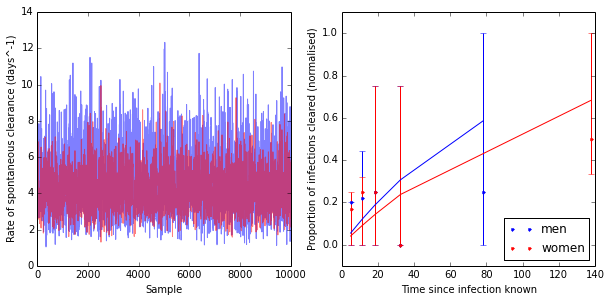

In [10]:
fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(221)
ax1.plot(sc_m, alpha=0.5)
ax1.plot(sc_f, 'r', alpha=0.5)
ax1.set_ylim([0,14])

ax2 = fig.add_subplot(222)

# men
simdat = zeros([n_sample, 5])
for i in xrange(n_sample):
    simp = 1 - exp(-array([5, 11.5, 18.5, 32.5, 78])*sc_m[i]/365.25)
    simdat[i] = binom.rvs([15,9,4,4,4], simp)
    
men = ax2.plot(
    [5, 11.5, 18.5, 32.5, 78],
    array([3,2,1,0,1])/array([15.,9.,4.,4.,4.]), 
    '.', label='men')
mlm = argmax(ll_m)

ax2.errorbar([5, 11.5, 18.5, 32.5, 78], 
            1 - exp(-array([5, 11.5, 18.5, 32.5, 78])*sc_m[mlm]/365.25),
            yerr = array([1 - exp(-array([5, 11.5, 18.5, 32.5, 78])*sc_m[mlm]/365.25) -
                    percentile(simdat, 2.5, 0)/array([15.,9.,4.,4.,4.]),
                    percentile(simdat, 97.5, 0)/array([15.,9.,4.,4.,4.]) -
                    1 + exp(-array([5, 11.5, 18.5, 32.5, 78])*sc_m[mlm]/365.25)
                    ]),
                    color='b')
# women
simdat = zeros([n_sample, 5])
for i in xrange(n_sample):
    simp = 1 - exp(-array([5, 11.5, 18.5, 32.5, 137.5])*sc_m[i]/365.25)
    simdat[i] = binom.rvs([12,28,4,8,6], simp)
    
women = ax2.plot(
    [5, 11.5, 18.5, 32.5, 137.5],
    array([2,7,1,0,3])/array([12.,28.,4.,8.,6.]), 
    '.r', label='women')
mlf = argmax(ll_f)

ax2.errorbar([5, 11.5, 18.5, 32.5, 137.5], 
            1 - exp(-array([5, 11.5, 18.5, 32.5, 137.5])*sc_f[mlf]/365.25),
            yerr = array([1 - exp(-array([5, 11.5, 18.5, 32.5, 137.5])*sc_f[mlf]/365.25) -
                    percentile(simdat, 2.5, 0)/array([12.,28.,4.,8.,6.]),
                    percentile(simdat, 97.5, 0)/array([12.,28.,4.,8.,6.]) -
                    1 + exp(-array([5, 11.5, 18.5, 32.5, 137.5])*sc_f[mlf]/365.25)
                    ]),
                    color='r')

ax2.set_ylim([-0.1, 1.1])

ax1.set_xlabel('Sample')
ax1.set_ylabel('Rate of spontaneous clearance (days^-1)')
ax2.set_xlabel('Time since infection known')
ax2.set_ylabel('Proportion of infections cleared (normalised)')

ax2.legend(loc=4)

Again, the chains appear to have converged well (left). In the posterior predictive check (right), point markers show the proportion of patients returning at each time point who had cleared their infection. The solid line and error bars indicate maximum likelihood and 95% of sample predictions, and cover all data points.

## Estimating national prevalence

The sampled parameter values are now used to infer prevalence in men and women in different age groups.

In [12]:
# this script contains the functions for three-part observations (tests, symptomatic diagnoses, asymptomatic diagnoses) too
# running this script takes a little while because of all the symbolic algebra
%run test_diag_fun.py

from numpy import *
from scipy.optimize import fsolve

In [13]:
# men first...
prev_m_15_19 = zeros(n_sample)
inc_m_15_19 = zeros(n_sample)
scr_m_15_19 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_m_15_19[i], scr_m_15_19[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_m[i], # proportion of incident infections which are symptomatic
                            sc_m[i], # rate of self-clear 
                            att_symp_m[i],
                            p_true_pos_m[i], 
                            p_false_pos_m[i]
                        ])])) - array([test_rate_m_15_19[i],diag_rate_m_15_19[i]]), [0.09, 0.25])
    prev_m_15_19[i] = dyn_fun(inc_m_15_19[i]*p_asymp_m[i], sc_m[i] + scr_m_15_19[i]*p_true_pos_m[i], inc_m_15_19[i]*(1-p_asymp_m[i]), sc_m[i] + att_symp_m[i]*p_true_pos_m[i])

In [14]:
prev_m_20_24 = zeros(n_sample)
inc_m_20_24 = zeros(n_sample)
scr_m_20_24 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_m_20_24[i], scr_m_20_24[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_m[i], # proportion of incident infections which are symptomatic
                            sc_m[i], # rate of self-clear 
                            att_symp_m[i],
                            p_true_pos_m[i], 
                            p_false_pos_m[i]
                        ])])) - array([test_rate_m_20_24[i],diag_rate_m_20_24[i]]), [0.09, 0.25])
    prev_m_20_24[i] = dyn_fun(inc_m_20_24[i]*p_asymp_m[i], sc_m[i] + scr_m_20_24[i]*p_true_pos_m[i], inc_m_20_24[i]*(1-p_asymp_m[i]), sc_m[i] + att_symp_m[i]*p_true_pos_m[i])

In [15]:
prev_m_15_24 = zeros(n_sample)
inc_m_15_24 = zeros(n_sample)
scr_m_15_24 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_m_15_24[i], scr_m_15_24[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_m[i], # proportion of incident infections which are symptomatic
                            sc_m[i], # rate of self-clear 
                            att_symp_m[i],
                            p_true_pos_m[i], 
                            p_false_pos_m[i]
                        ])])) - array([test_rate_m_15_24[i],diag_rate_m_15_24[i]]), [0.09, 0.25])
    prev_m_15_24[i] = dyn_fun(inc_m_15_24[i]*p_asymp_m[i], sc_m[i] + scr_m_15_24[i]*p_true_pos_m[i], inc_m_15_24[i]*(1-p_asymp_m[i]), sc_m[i] + att_symp_m[i]*p_true_pos_m[i])

In [16]:
# ... then women
prev_f_15_19 = zeros(n_sample)
inc_f_15_19 = zeros(n_sample)
scr_f_15_19 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_15_19[i], scr_f_15_19[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_f[i], # proportion of incident infections which are symptomatic
                            sc_f[i], # rate of self-clear 
                            att_symp_f[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_15_19[i],diag_rate_f_15_19[i]]), [0.03, 0.44])
    prev_f_15_19[i] = dyn_fun(inc_f_15_19[i]*p_asymp_f[i], sc_f[i] + scr_f_15_19[i]*p_true_pos_f[i], inc_f_15_19[i]*(1-p_asymp_f[i]), sc_f[i] + att_symp_f[i]*p_true_pos_f[i])

In [17]:
prev_f_20_24 = zeros(n_sample)
inc_f_20_24 = zeros(n_sample)
scr_f_20_24 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_20_24[i], scr_f_20_24[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_f[i], # proportion of incident infections which are symptomatic
                            sc_f[i], # rate of self-clear 
                            att_symp_f[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_20_24[i],diag_rate_f_20_24[i]]), [0.03, 0.44])
    prev_f_20_24[i] = dyn_fun(inc_f_20_24[i]*p_asymp_f[i], sc_f[i] + scr_f_20_24[i]*p_true_pos_f[i], inc_f_20_24[i]*(1-p_asymp_f[i]), sc_f[i] + att_symp_f[i]*p_true_pos_f[i])

In [18]:
prev_f_15_24 = zeros(n_sample)
inc_f_15_24 = zeros(n_sample)
scr_f_15_24 = zeros(n_sample)

for i in xrange(n_sample):
    [inc_f_15_24[i], scr_f_15_24[i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    x, array([
                            1-p_asymp_f[i], # proportion of incident infections which are symptomatic
                            sc_f[i], # rate of self-clear 
                            att_symp_f[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_15_24[i],diag_rate_f_15_24[i]]), [0.03, 0.44])
    prev_f_15_24[i] = dyn_fun(inc_f_15_24[i]*p_asymp_f[i], sc_f[i] + scr_f_15_24[i]*p_true_pos_f[i], inc_f_15_24[i]*(1-p_asymp_f[i]), sc_f[i] + att_symp_f[i]*p_true_pos_f[i])

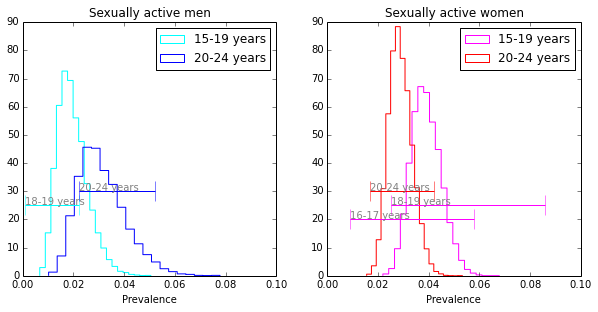

In [19]:
fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(221)
h_2012_m_15_19 = ax1.hist(prev_m_15_19, bins=20, normed=true, histtype='step', color='cyan', label='15-19 years')
h_2012_m_20_24 = ax1.hist(prev_m_20_24, bins=20, normed=true, histtype='step', color='blue', label='20-24 years')
ax1.errorbar(0.001, 25, xerr=[[0],[0.022-0.001]], ecolor='cyan', capsize=10)
ax1.errorbar(0.022, 30, xerr=[[0],[0.052-0.022]], ecolor='blue', capsize=10)
ax1.annotate('18-19 years', [0.001, 25], color='0.5')
ax1.annotate('20-24 years', [0.022, 30], color='0.5')
ax1.set_xlabel('Prevalence')
ax1.set_xlim(0,0.1)
ax1.set_ylim(0,90)
ax1.set_title('Sexually active men')
ax1.legend()

ax2 = fig.add_subplot(222)
h_2012_f_15_19 = ax2.hist(prev_f_15_19, range=[min(prev_f_15_19),max(prev_f_15_19)], bins=20, normed=true, histtype='step', color='fuchsia', label='15-19 years')
h_2012_f_20_24 = ax2.hist(prev_f_20_24, range=[min(prev_f_20_24),max(prev_f_20_24)], bins=20, normed=true, histtype='step', color='r', label='20-24 years')
ax2.errorbar(0.009, 20, xerr=[[0],[0.058-0.009]], ecolor='fuchsia', capsize=10)
ax2.errorbar(0.025, 25, xerr=[[0],[0.086-0.025]], ecolor='fuchsia', capsize=10)
ax2.errorbar(0.017, 30, xerr=[[0],[0.042-0.017]], ecolor='r', capsize=10)
ax2.annotate('16-17 years', [0.009, 20], color='0.5')
ax2.annotate('18-19 years', [0.025, 25], color='0.5')
ax2.annotate('20-24 years', [0.017, 30], color='0.5')
ax2.set_xlabel('Prevalence')
ax2.set_xlim(0,0.1)
ax2.set_ylim(0,90)
ax2.set_title('Sexually active women')
ax2.legend()

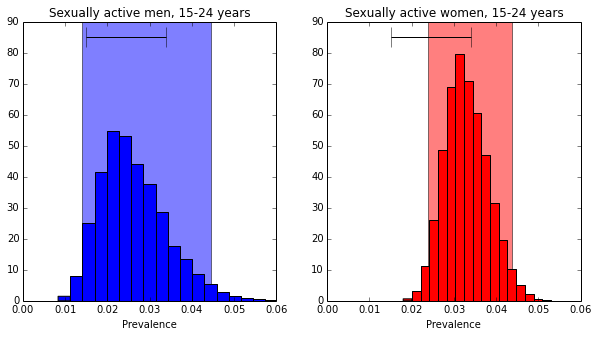

In [20]:
fig = plt.figure(figsize = (10,5))

ax1 = fig.add_subplot(121)
h_2012_m_15_24 = ax1.hist(prev_m_15_24, bins=20, normed=true, color='b')
ax1.fill_betweenx([0,100], percentile(prev_m_15_24, 2.5), percentile(prev_m_15_24, 97.5), facecolor='b', alpha=0.5)
ax1.errorbar(0.015, 85, xerr=[[0],[0.034-0.015]], ecolor='k', capsize=10)
ax1.set_xlabel('Prevalence')
ax1.set_xlim(0,0.06)
ax1.set_ylim(0,90)
ax1.set_title('Sexually active men, 15-24 years')

ax2 = fig.add_subplot(122)
h_2012_f_15_24 = ax2.hist(prev_f_15_24, range=[min(prev_f_15_24),max(prev_f_15_24)], bins=20, normed=true, color='r')
ax2.fill_betweenx([0,100], percentile(prev_f_15_24, 2.5), percentile(prev_f_15_24, 97.5), facecolor='r', alpha=0.5)
ax2.errorbar(0.015, 85, xerr=[[0],[0.034-0.015]], ecolor='k', capsize=10)
ax2.set_xlabel('Prevalence')
ax2.set_xlim(0,0.06)
ax2.set_ylim(0,90)
ax2.set_title('Sexually active women, 15-24 years')

## Symptomatic and asymptomatic diagnoses

Although the data does not report the number of diagnoses that were in symptomatic and asymptomatic cases, we can propose different numbers of symptomatic and asymptomatic diagnoses and examine the inferences which would have followed in each case.

In [20]:
# men first...
prev_m = zeros(n_sample)
inc_m = zeros(n_sample)
scr_m = zeros(n_sample)
p_symp_m = zeros(n_sample)

# there were 48387 diagnoses in men aged 15-24
# don't allow all symptomatic or all asymptomatic - messes with gamma distributions
sample_symp_m = ceil(48386*random.uniform(size = n_sample))
diag_rate_symp_m_15_24 = random.gamma(sample_symp_m, 1, size=n_sample)/pop_active_m_15_24

sample_asymp_m = 48387 - sample_symp_m
diag_rate_asymp_m_15_24 = random.gamma(sample_asymp_m, 1, size=n_sample)/pop_active_m_15_24

for i in xrange(n_sample):
    [inc_m[i], scr_m[i], p_symp_m[i]] = fsolve(lambda x: test_diag_sym_asym_fun(concatenate([
                    x, array([
                            sc_m[i], # rate of self-clear 
                            att_symp_m[i],
                            p_true_pos_m[i], 
                            p_false_pos_m[i]
                        ])])) - array([test_rate_m_15_24[i],diag_rate_symp_m_15_24[i],diag_rate_asymp_m_15_24[i]]), 
                                               [0.01, 0.3, 0.21])
    prev_m[i] = dyn_fun(
        inc_m[i]*(1-p_symp_m[i]), 
        sc_m[i] + scr_m[i]*p_true_pos_m[i], 
        inc_m[i]*p_symp_m[i], 
        sc_m[i] + att_symp_m[i]*p_true_pos_m[i])

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/optimize/minpack.py:236: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/optimize/minpack.py:236: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/optimize/minpack.py:236: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)


In [21]:
# ...then women
prev_f = zeros(n_sample)
inc_f = zeros(n_sample)
scr_f = zeros(n_sample)
p_symp_f = zeros(n_sample)

# there were 88101 diagnoses in women aged 15-24
# don't allow all symptomatic or all asymptomatic - messes with gamma distributions
sample_symp_f = ceil(88100*random.uniform(size = n_sample))
diag_rate_symp_f_15_24 = random.gamma(sample_symp_f, 1, size=n_sample)/pop_active_f_15_24

sample_asymp_f = 88101 - sample_symp_f
diag_rate_asymp_f_15_24 = random.gamma(sample_asymp_f, 1, size=n_sample)/pop_active_f_15_24

for i in xrange(n_sample):
    [inc_f[i], scr_f[i], p_symp_f[i]] = fsolve(lambda x: test_diag_sym_asym_fun(concatenate([
                    x, array([
                            sc_f[i], # rate of self-clear 
                            att_symp_f[i],
                            p_true_pos_f[i], 
                            p_false_pos_f[i]
                        ])])) - array([test_rate_f_15_24[i],diag_rate_symp_f_15_24[i],diag_rate_asymp_f_15_24[i]]), 
                                               [0.01, 0.3, 0.21])
    prev_f[i] = dyn_fun(
        inc_f[i]*(1-p_symp_f[i]), 
        sc_f[i] + scr_f[i]*p_true_pos_f[i], 
        inc_f[i]*p_symp_f[i], 
        sc_f[i] + att_symp_f[i]*p_true_pos_f[i])

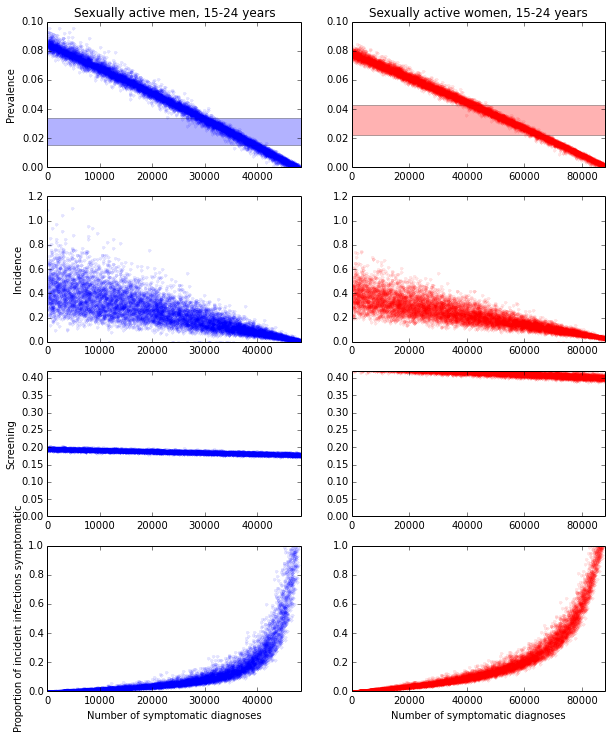

In [22]:
fig = plt.figure(figsize = (10,12))

xtk_m = [0, 10000, 20000, 30000, 40000] # x-axis ticks for men
xtk_f = [0, 20000, 40000, 60000, 80000] # x-axis ticks for women

ax1 = fig.add_subplot(421)
ax1.plot(sample_symp_m, prev_m, '.', alpha = 0.1)
ax1.fill_between([0,50000], 0.015, 0.034, facecolor='b', alpha=0.3)
ax1.set_xlim([0,48387])
ax1.set_ylim([0,0.1])
ax1.set_xticks(xtk_m)
ax1.set_ylabel('Prevalence')
ax1.set_title('Sexually active men, 15-24 years')

ax2 = fig.add_subplot(422)
ax2.plot(sample_symp_f, prev_f, '.r', alpha = 0.1)
ax2.fill_between([0,100000], 0.022, 0.043, facecolor='r', alpha=0.3)
ax2.set_xlim([0,88101])
ax2.set_ylim([0,0.1])
ax2.set_xticks(xtk_f)
ax2.set_title('Sexually active women, 15-24 years')

ax3 = fig.add_subplot(423)
ax3.plot(sample_symp_m, inc_m, '.', alpha = 0.1)
ax3.set_xlim([0,48387])
ax3.set_ylim([0,1.2])
ax3.set_xticks(xtk_m)
ax3.set_ylabel('Incidence')

ax4 = fig.add_subplot(424)
ax4.plot(sample_symp_f, inc_f, '.r', alpha = 0.1)
ax4.set_xlim([0,88101])
ax4.set_ylim([0,1.2])
ax4.set_xticks(xtk_f)

ax5 = fig.add_subplot(425)
ax5.plot(sample_symp_m, scr_m, '.', alpha = 0.1)
ax5.set_xlim([0,48387])
ax5.set_ylim([0,0.42])
ax5.set_ylabel('Screening')
ax5.set_xticks(xtk_m)

ax6 = fig.add_subplot(426)
ax6.plot(sample_symp_f, scr_f, '.r', alpha = 0.1)
ax6.set_xlim([0,88101])
ax6.set_ylim([0,0.42])
ax6.set_xticks(xtk_f)

ax7 = fig.add_subplot(427)
ax7.plot(sample_symp_m, p_symp_m, '.', alpha = 0.1)
ax7.set_xlim([0,48387])
ax7.set_ylim([0,1])
ax7.set_xlabel('Number of symptomatic diagnoses')
ax7.set_ylabel('Proportion of incident infections symptomatic')
ax7.set_xticks(xtk_m)

ax8 = fig.add_subplot(428)
ax8.plot(sample_symp_f, p_symp_f, '.r', alpha = 0.1)
ax8.set_xlim([0,88101])
ax8.set_ylim([0,1])
ax8.set_xlabel('Number of symptomatic diagnoses')
ax8.set_xticks(xtk_f)


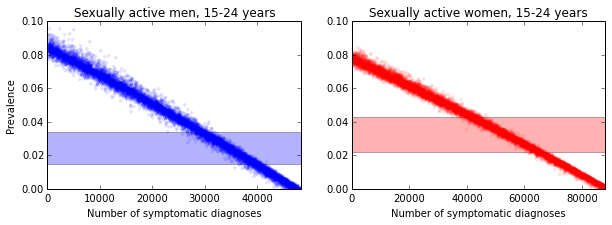

In [23]:
# plot only the prevalence, for figure in paper

fig = plt.figure(figsize = (10,3))

xtk_m = [0, 10000, 20000, 30000, 40000] # x-axis ticks for men
xtk_f = [0, 20000, 40000, 60000, 80000] # x-axis ticks for women

ax1 = fig.add_subplot(121)
ax1.plot(sample_symp_m, prev_m, '.', alpha = 0.1)
ax1.fill_between([0,50000], 0.015, 0.034, facecolor='b', alpha=0.3)
ax1.set_xlim([0,48387])
ax1.set_ylim([0,0.1])
ax1.set_xticks(xtk_m)
ax1.set_xlabel('Number of symptomatic diagnoses')
ax1.set_ylabel('Prevalence')
ax1.set_title('Sexually active men, 15-24 years')

ax2 = fig.add_subplot(122)
ax2.plot(sample_symp_f, prev_f, '.r', alpha = 0.1)
ax2.fill_between([0,100000], 0.022, 0.043, facecolor='r', alpha=0.3)
ax2.set_xlim([0,88101])
ax2.set_ylim([0,0.1])
ax2.set_xticks(xtk_f)
ax2.set_xlabel('Number of symptomatic diagnoses')
ax2.set_title('Sexually active women, 15-24 years')